Welcome to the EPISOL Colab Playground!



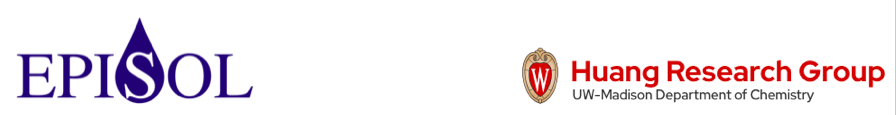

The 3D reference interaction site model (3DRISM) provides an efficient grid-based solvation model to compute the structural and thermodynamic properties of biomolecules in aqueous solutions, in this notebook we will walk through two examples: a neutral, and charged solute. In this notebook we will walk through a 3DRISM calculation on a larger solute - proteins, nucleic acids, and combininations thereof. T
* goals:
  * perform 3DRISM calculations on larger solutes using EPISOL utilizing the python interface
  * determine solvent distibutions around ares of interest
  * workthrough a calculation that fails to converge within the given number of steps
  * place explicit water - oxygens using commands specific to the python interface
  * determine high-energy waters and their importance

In [ ]:
#@title ##Download and Install Episol
#@markdown ($\approx 2$min) Stable as of 07/01/25 eprism v1.2.6
%%capture
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
#%cd ../home/
%cd $HOME/
%mkdir episol
%cd episol
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/fftw/fftw-3.3.8.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded fftw files"
!echo "+++++++++++++++++++"
!tar -xzf fftw-3.3.8.tar.gz
%cd fftw-3.3.8/
#!./configure --prefix=/home/fftw-3.3.8
!./configure --prefix=$HOME/episol/fftw-3.3.8
!make
!make install
%cd ../
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/kernel/release.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded Episol files"
!echo "+++++++++++++++++++"
!tar -xzf release.tar.gz
%cd release/
#!./configure --with-fftw=/home/fftw-3.3.8
!./configure --with-fftw=$HOME/episol/fftw-3.3.8
!make
!make install
#%cd /content
########################### WRAPEPR
import subprocess
import os
import threading
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
%%capture
#@title Install some python packages for topology generation ($\approx$ 2.5min)
#@markdown This will prompt a 'crash' then restart in our colab session, this is necessary, just keep moving

#@markdown (if you are using the notebook offline this wont be necessary, as presumably you'll have your own forcefield to generate topologies)
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install --yes -c conda-forge numpy=1.26.4 openmm pdbfixer parmed mdanalysis py3dmol pymol-open-source#rdkit openff-toolkit
#openmm pdbfixer parmed mdanalysis py3dmol rdkit


In [ ]:
#@title import our download packages
%%capture
import matplotlib.pyplot as plt
import openmm as mm
from   openmm import app
from   openmm.unit import *
import py3Dmol# as pymol
import MDAnalysis as md
import parmed as chem
from openff.toolkit.topology import Molecule, Topology
import numpy as np
import MDAnalysis.transformations as mdt
import pdbfixer
%cd /content/

In [ ]:
#@title This is the code for the python-Episol interface
###########################
import subprocess
import os
import threading
import pandas as pd
import matplotlib.pyplot as plt

class epipy:
    def __init__(self,solute_structure,solute_topology,to_gro=False,gen_idc=False,
                 convert=False,recenter=False,box_size=[10,10,10]):
      # moving solute and solvent to __init__ because it seems more natural
      # user can still overwrite if need be
      # initialize everything so the user can define the parameters
      # on their own if need be
      self.cmd_path = "" #path to eprism command
      self.grid = [] # number of grids per unit cell LxWxH
      self.closure = 'PSE3'
      self.path = ""
      self.ndiis = 5
      self.solute_path = ""
      self.solvent_path = ""#~/EPISOL-1.1.326/solvent/"
      self.r_c = 1
      self.coulomb = 'coulomb'
      self.delvv = 0.5
      self.err_tol = 1e-08
      self.dynamic_delvv = 1
      self.T = 298
      self.log = 'episol_out.log'
      self.threads = threading.active_count()
      self.rism_args = str()
      self.test_args = str()
      self.rism_cmd = str()
      #self.out_file = self.log#str()
      self.get_eprism_path = ''.join([chr(i) for i in subprocess.check_output(['whereis eprism3d'],shell=True)[:-1]]).split()[1][:-8]
      ## initialize solute and solvent right at the begining
      # you can do this later onif you want to change files
      self.solute(solute_structure,solute_topology,to_gro=False,gen_idc=False,convert=False,recenter=False,box_size=[10,10,10])
      self.solvent()
####################################################################################
# HERE I AM MOVING THIS TO __INIT__
####################################################################################
    def solute(self,solute_structure,solute_topology,to_gro=False,gen_idc=False,convert=False,recenter=False,box_size=[10,10,10]):
        """solute file (solute/top/prmtop, or a folder)"""
        self.structure_file = solute_structure
        if convert:
            subprocess.run([f"gmxtop2solute -p {solute_topology} -o {solute_topology[:-4]}.solute"],shell=True)
            self.solute_top = f"{solute_topology[:-4]}.solute"
            print(f"converted {solute_topology} to {solute_topology[:-4]}.solute")
            if gen_idc:
                subprocess.run([f"{self.get_eprism_path}generate-idc.sh {solute_topology[:-4]}.solute > idc_{solute_topology[:-4]}.solute"],shell=True)
                self.solute_top = f'idc_{solute_topology[:-4]}.solute'
                print(f"generated idc-enabled solute file to: idc_{solute_topology[:-4]}.solute ")
        else:
            self.solute_top = solute_topology
        ####################################################################################
        # THIS IS KIND OF TRASH TO INCLUDE: LET THEM USE GMX ON THEIR OWN IF THEY WANT
        ####################################################################################
        if recenter:
            subprocess.run([f"gmx  editconf -f {self.structure_file} -c yes -box {box_size[0]} {box_size[1]} {box_size[2]} -o {self.structure_file[:-4]}.gro"],shell=True)
            self.structure_file = f"{self.structure_file[:-4]}.gro"
        if to_gro:
            subprocess.run([f"gmx  editconf -f {self.structure_file} -o {self.structure_file[:-4]}.gro"],shell=True)
            self.structure_file = f"{self.structure_file[:-4]}.gro"
        #box = [box_size,box_size,box_size]
        #self.rism_args += f" -f {self.path+self.solute_path+self.structure_file} -s {self.path+self.solute_path+self.solute_top}"
      ####################################################################################
        if f"{self.path+self.solute_path+self.structure_file}"[-3:] == 'pdb':
          self.file_type = 'pdb'
          with open(f"{self.path+self.solute_path+self.structure_file}",'r') as sol:
              for line in sol:
                tmp = line.split()
                if tmp[0] == "CRYST1":
                  self.solute_box = [tmp[1],tmp[2],tmp[3]]
                  break
          sol.close()

        elif f"{self.path+self.solute_path+self.structure_file}"[-3:] == 'gro':
          self.file_type = 'gro'
          """https://stackoverflow.com/questions/3346430/
          what-is-the-most-efficient-way-to-get-first-and-last-line-of-a-text-file/18603065#18603065"""
          import os
          with open(f"{self.path+self.solute_path+self.structure_file}", 'rb') as f:
              try:
                  f.seek(-2, os.SEEK_END)
                  while f.read(1) != b'\n':
                      f.seek(-2, os.SEEK_CUR)
              except OSError:
                  f.seek(0)
              last_line = f.readline().decode()
        self.solute_box = [float(val) for val in last_line.split()]

    def solvent(self,solvent_topology='tip3p-amber14.01A.gaff'):
        """iet parameter file, can be screen/con"""
        self.solvent_top = solvent_topology
        #self.rism_args += f" -p {self.path+self.solvent_path+self.solvent_top}"
####################################################################################
####################################################################################
    def rism(self,step=500,resolution=1,args=('all')):
        """
        step :: int(), Number of SCF steps to perform
        resolution :: int(), grid resolution of box (will override if previously set)
        args :: string(), values to save to the dump file; options below:
        ++++++++++++++++++++++++++ SAVE ARGS ++++++++++++++++++++++++++
        all : reports all of the below
        command : save the exact command that was run when the file was produced
        guv : g(r) foreach grid point
        ld : smoothed g(r)  i.e. g(r) convolved with kernel
        coul : coulombic potential at each grid
        excess : mu^ex at each grid
        """
        self.rism_step = step
        self.resolution = resolution
        #self.rism_cmd +=  f" -cmd closure={self.closure} rism,step={self.rism_step}"#f" rism,step={self.rism_step}"
        ###
        tmp = self.solute_box
        if self.file_type == 'gro':
          # box is in nm
          convert = (10)/resolution
          self.grid = [i*convert for i in tmp]
        if self.file_type == 'pdb':
          # box is in Angstrom
          convert = 1/resolution
          self.grid = [i*convert for i in tmp]

        self.save_command = f' save:{args}'

    def report(self,out_file_name:str='episol_out',args=('all')):
        self.log = out_file_name
        cmd_string = " report:"
        for arg in args:
            cmd_string += f"{arg}"
        self.to_report = f" {cmd_string}" #{self.rism_cmd} {cmd_string}"

    def get_version(self):
        temp = subprocess.check_output([f'{self.cmd_path}eprism3d --version'],shell=True)
        return ''.join([chr(i) for i in temp[:-1]])

    def get_help(self,search_str:str):
      xx = subprocess.run(["eprism3d","--h",search_str],capture_output=True)
      xv = ''.join([chr(i) for i in xx.stdout[:-1]])
      print(xv)

    def test(self,nt=1,v=1):
        """
        v :: int(), verbose rating
        nt :: int(), number of threads to use
        """
        self.test_args += f" -f {self.path+self.solute_path+self.structure_file} -s {self.path+self.solute_path+self.solute_top}"
        self.test_args += f" -p {self.path+self.solvent_path+self.solvent_top}"
        self.test_args += f" -coulomb {self.coulomb}"
        #self.rism_cmd += f' -cmd closure={self.closure} rism,step={self.rism_step}'
        self.test_args += f" -rc {self.r_c} "
        self.test_args += f" -T {self.T}"
        self.test_args += f" -log {self.log}.log"
        self.test_args += f" -nr {self.grid[0]}x{self.grid[1]}x{self.grid[2]}"
        self.test_args += f" -ndiis {self.ndiis}"
        self.test_args += f" -errtolrism {self.err_tol}"
        self.test_args += f" -delvv {self.delvv}"
        self.test_args += f" -dynamic-delvv {self.dynamic_delvv}"
        self.test_args += " -pwd ./" #"~/mnt/f/water_proj"
        self.test_args += f" -o {self.log}"
        self.test_args += f" -cmd closure={self.closure} rism,step={self.rism_step}"#f" rism,step={self.rism_step}"#self.rism_cmd
        self.test_args += self.to_report
        self.test_args += self.save_command
        ###
        self.test_args += f' -nt {nt} -test'
        subprocess.run([f"{self.cmd_path}eprism3d {self.test_args}"],shell=True)
        self.test_args = ''

        with open(f"{self.log}.log",'r') as f:
          #mem = str()
          for line in f:
            tmp = line.split()
            if tmp[0] == "Memory":
              mem = f'{tmp[5]}{tmp[6]}'
              break
        f.close()
        return mem

    def kernel(self,nt=1,v=1):
        """
        v :: int(), verbose rating
        nt :: int(), number of threads to use
        """
        self.rism_args += f" -f {self.path+self.solute_path+self.structure_file} -s {self.path+self.solute_path+self.solute_top}"
        self.rism_args += f" -p {self.path+self.solvent_path+self.solvent_top}"
        self.rism_args += f" -coulomb {self.coulomb}"
        #self.rism_cmd += f' -cmd closure={self.closure} rism,step={self.rism_step}'
        self.rism_args += f" -rc {self.r_c} "
        self.rism_args += f" -T {self.T}"
        self.rism_args += f" -log {self.log}.log"
        self.rism_args += f" -nr {self.grid[0]}x{self.grid[1]}x{self.grid[2]}"
        self.rism_args += f" -ndiis {self.ndiis}"
        self.rism_args += f" -errtolrism {self.err_tol}"
        self.rism_args += f" -delvv {self.delvv}"
        self.rism_args += f" -dynamic-delvv {self.dynamic_delvv}"
        self.rism_args += " -pwd ./" #"~/mnt/f/water_proj"
        self.rism_args += f" -o {self.log}"
        self.rism_args += f" -cmd closure={self.closure} rism,step={self.rism_step}"#f" rism,step={self.rism_step}"#self.rism_cmd
        self.rism_args += self.to_report
        self.rism_args += self.save_command
        # using unix system is better to run subprocess as
        # argument strings, rather than **args
        # i.e. better "exe.exe -command value" than "exe.exe","command","value"
        #self.rism_args += f' save:all -nt {nt} -v {v}'
        self.rism_args += f' -nt {nt} -v {v}'
        subprocess.run([f"{self.cmd_path}eprism3d {self.rism_args}"],shell=True)#,self.rism_args],shell=True)
        self.rism_args = ''
        with open(f'{self.log}.log','r') as f:
          for line in f:
            tmp = line.split()
            if tmp[0][:4] == "RISM":
              out = float(tmp[4])
              step = tmp[2]
        f.close()
        if out > self.err_tol:
          print(f"Failed to reach desired err_tol of {self.err_tol}")
          print(f"Actual error: {out}")
          print(f"Difference: {self.err_tol - out}")
          print(f"RISM finished at step {step}")
        else:
          print(f"Calculation finished in {step} steps ")
          print(f"err_tol: {self.err_tol} actual: {out} ")

    def dump(self,file_name='',out_name=False,list_values=False,value_to_extract=1):
        if not out_name:
            out_name = file_name
        if file_name == '':
          file_name = f'{self.log}.ts4s'

        if list_values:
            thold = ''.join([chr(i) for i in subprocess.check_output([f"ts4sdump -f {file_name} -l"],shell=True)]).split('\n')
            for item in thold:
              print(item)
        else:
          subprocess.run([f"ts4sdump -f {file_name} -e {value_to_extract} > {out_name}.txt"],shell=True)
        self.extracted_file = f'{out_name}.txt'

    def err(self,log_file_name=False):
      """
      This function reads a log file and returns
      the SCF stdev in an array
      ======================== INPUT
      log_file_name :: string, name of .log file
      ======================== Returns
      out_arr :: np.array() with shape (1, # steps)
      array index represents the SCF step
      """
      if not log_file_name:
        with open(f'{self.log}.log','r') as f:
          out_arr = []
          for line in f:
            tmp = line.split()
            if tmp[0][:4] == "RISM":
              out_arr.append(float(tmp[4]))
              #step = tmp[2]
        f.close()
        return np.array(out_arr)

    def reader(self,file_in:str,laplacian=False,file_out:str='out',dx=False):
      from numpy import loadtxt,zeros,copy
      from scipy.ndimage import laplace
      """
      This function takes in an uncompressed dump file txt file
      it reads the grid size and shape
      If specified we can save/export to a dx file which can be loaded into pymol/vmd/etc.
      =================================
      file_in :: the decompress txt file from our ts4s dump command
      grid_spacing :: [x,y,z] values for \delta grid, e.g. grid spacing of 0.5A would
      have grid_spacing = [0.5,0.5,0.5]
      ---------- IF DX=TRUE ---------------
      file_out :: filename for saved dx file
      ################# WARNINGS ################
      since the dx file was made by IBM in the 90s
      many nont-so-modern softwares will struggle to read
      dx files with comments and it appears many follow their own
      format specifications
      """
      grid_spacing = [self.resolution for _ in range(3)]
      #[i/j for (i,j) in zip(self.solute_box,self.grid)]

      xs,ys,zs = loadtxt(file_in)[-1][:3]
      x = loadtxt(file_in,usecols=(3))
      #xs,ys,zs
      shaped = zeros((int(xs),int(ys),int(zs)))
      cont = int()
      for zval in range(int(zs)):
        for yval in range(int(ys)):
            for xval in range(int(xs)):
                shaped[xval][yval][zval] = x[cont]#np.linalg.norm(x[cont])
                cont +=1
      if laplacian and not dx:
        return laplace(shaped)
      elif not dx:
        return shaped
      if dx:
        with open(f'{file_out}.dx','w+') as outfile:
          outfile.write(f"""object 1 class gridpositions counts     {xs}     {ys}      {zs}
origin 0.0000   0.0000   0.0000
delta  {grid_spacing[0]} 0 0
delta  0 {grid_spacing[1]} 0
delta  0 0  {grid_spacing[2]}
object 2 class gridconnections counts     {xs}     {ys}      {zs}
object 3 class array type double rank 0 items {int(xs*ys*zs)} follows\n""")
          for ind, val in enumerate(shaped.flatten()):
            outfile.write(f"{val:0.5e} ")
            if (ind != 0) and (ind % 3 == 0):
              outfile.write("\n")
        outfile.close()

    def placement(self,num_waters_to_place:int,radius=1.9269073728633292,filename=False,grid_spacing=None,write_pdb=False,outname='out.pdb',weight=None):
      import numpy as np
      import datetime
      """function selects top distribution
      then places water there, then removes that density
      and continues to look. kind of like placevent.
      =============================
      filename:: txt file containing density
      inputgrid:: md.Grid object
      outname:: string for pdb file
      num_waters_to_place:: number of waters to place
      radius:: distance around selected point to omit from remaining placement
      ideal_radius = ((10**3)/(4/3)/(np.pi)/33.3679)**(1/3) based on number density of water
      grid_spacing:: conversion from array indices to angstrom, units of 1/A
      """
      if grid_spacing is None:
        # you can overide the grid spacing if need be
        grid_spacing = self.resolution
      if not filename:
        filename = f'{self.log}.txt'

      xs,ys,zs = np.loadtxt(filename)[-1][:3]
      x = np.loadtxt(filename,usecols=(3))

      shaped = np.zeros((int(xs),int(ys),int(zs)))
      cont = int()
      for zval in range(int(zs)):
        for yval in range(int(ys)):
            for xval in range(int(xs)):
                shaped[xval][yval][zval] = x[cont]#np.linalg.norm(x[cont])
                cont +=1

      inputgrid = np.copy(shaped)
      x = np.arange(0,inputgrid.shape[0])
      y = np.arange(0,inputgrid.shape[1])
      z = np.arange(0,inputgrid.shape[2])
      out_array = []
      for wat in range(num_waters_to_place):
          r_x,r_y,r_z = np.where(inputgrid == np.max(inputgrid))
          r_x,r_y,r_z = r_x[0],r_y[0],r_z[0]
          out_array.append([float(r_x),float(r_y),float(r_z)])
          mask = (x[:,np.newaxis,np.newaxis]-r_x)**2 + (y[np.newaxis,:,np.newaxis]-r_y)**2 + (z[np.newaxis,np.newaxis,:]-r_z)**2  < (radius/grid_spacing)**2
          inputgrid[mask] = -1
      ################################
      if write_pdb:
        x,y,z = self.grid
        with open(f'{outname}.pdb','w+') as pdb:
            pdb.write(f"CRYST1    {str(x).ljust(4,'0')}    {str(y).ljust(4,'0')}    {str(z).ljust(4,'0')}  90.00  90.00  90.00 P 1           1\n")
            count = 1
            for val in np.array(out_array)*grid_spacing:#guess2:
                pdb.write(f"ATOM   {str(count).rjust(4,' ')}  O    HOH  A{str(count).rjust(3,' ')} {val[0]:8.3f} {val[1]:8.3f} {val[2]:8.3f}\n")
                count +=1

      return np.array(out_array)*grid_spacing

    def select_coords(self,in_file:str,sele:str,atom_sele:str=None,conv_fact:int=10):
      """
      in_file: .gro file
      sele: selection string -> resname only so far
      returns:

      ========
      conv_fact: convert from nm to grid-bits
      for .gro this is X nm*(10A/1nm)
      """
      import numpy as np
      # this is where we select the selection string
      tmp_string = sele.split()
       # Xnm*(10A/1nm)
      with open(f'{in_file}','r') as r:
          count = int()
          atom_count = int()
          out_dict = {}
          for line in r:
            count += 1
            if count == 2:
              atom_count = int(line.split()[0])
            if count == atom_count+2:
              break # this is the end of the file
            ###########
            if count > 2: # ignore header
              try:
                res_id = line[:5].split()[0]
                res_name = line[5:10].split()[0]
                # there is probably a better way of doing this
                if f"{res_name+res_id}" not in out_dict.keys():
                  # if the residue is not in the dictionary, add it
                  out_dict[f"{res_name+res_id}"] = {}
                else:
                  #print(line[20:28].split()[0])
                  out_dict[f"{res_name+res_id}"][f"{line[10:15].split()}"] = conv_fact*np.array([float(line[20:28].split()[0]),
                                                                                      float(line[28:36].split()[0]),
                                                                                      float(line[36:44].split()[0])])
              except ValueError:
                print(f"ERROR OCCURED AT LINE: {count}")
                continue
      # now we return the x,y,z positions ONLY
      out_array = np.array([])
      for val in out_dict.keys():
        if val[:3] == sele:
          # this uh is a pretty bad way of doing this
          out_array = np.append(out_array,[i for i in out_dict[val].values()])
      #out_array = np.array(out_array)
      #print('out array',out_array)
      """if len(out_array.shape) > 2:
        # this is a bad way of doing this
        y,z,_ = out_array.shape
        out_array = out_array.flatten()#.shape
        out_array = out_array.reshape((y*z,3))"""
      out_array = out_array.reshape((int(len(out_array)/3),3))

      return out_array

    def select_around(self,rism_grid,in_coords,around=5.0):
      import numpy as np
      """
      function will take an input grid, select the values surrounding the input
      coordinates according to the user, then return the array surrounding the coords
      while the values greater than the cutoff distance are set to np.NaN
      this is so plotting is easier
      """
      conversion = self.resolution
      around = around/conversion # must convert A to grids
      rism_grid = np.copy(rism_grid)
      x = np.arange(0,rism_grid.shape[0])
      y = np.arange(0,rism_grid.shape[1])
      z = np.arange(0,rism_grid.shape[2])
      #index_grid = np.ndarray(shape=(rism_grid.shape[0],rism_grid.shape[1],rism_grid.shape[2]))
      index_grid = np.full((rism_grid.shape[0],rism_grid.shape[1],rism_grid.shape[2]),False,dtype=bool)
      #print(index_grid.shape)
      for coords in in_coords:
        #print(coords)
        #x_r,y_r,z_r = int(coords[0]),int(coords[1]),int(coords[2])
        x_r,y_r,z_r = float(coords[0])/conversion,float(coords[1])/conversion,float(coords[2])/conversion
        #mask = (x[np.newaxis,:,:]-x_r)**2+(y[:,np.newaxis,:]-y_r)**2+(z[:,:,np.newaxis]-z_r)**2 < around**2
        #print(x[np.newaxis,:,:])
        index_grid[(x[:,np.newaxis,np.newaxis]-x_r)**2+(y[np.newaxis,:,np.newaxis]-y_r)**2+(z[np.newaxis,np.newaxis,:]-z_r)**2 < around**2] = True
        #rism_grid[(x[np.newaxis,:,:]-x_r)**2+(y[:,np.newaxis,:]-y_r)**2+(z[:,:,np.newaxis]-z_r)**2 < around**2] #= np.nan
        #out_grid = rism_grid[index_grid]#np.where(rism_grid == rism_grid[index_grid])]
      return np.where(index_grid == True,rism_grid,np.nan)

    def extract_grid(self,input_file:str,sele:str='guv',out_name:str='out'):
      """
      This function extracts calc. data from the dump file
      by searching for the value corresponding to the selection string
      This way you dont need to list values to extract them
      """
      assert sele != 'cmd', 'you selected the saved command (cmd)'
      thold = ''.join([chr(i) for i in subprocess.check_output([f"ts4sdump -f {input_file} -l"],shell=True)]).split('\n')
      for val in thold:
        try:
          tmp_str = val.split('@')[0].split()#[1] #.index('guv')
          if tmp_str[1] == sele.strip():
            #print(tmp_str[0])
            value_to_extract = tmp_str[0]
        except IndexError:
          continue
      subprocess.run([f"ts4sdump -f {input_file} -e {value_to_extract} > {out_name}.txt"],shell=True)
          #self.extracted_file = f'{out_name}.txt'
      return

    def select_grid(self,input_string:str='guv',coord_array=None):
      """
      select values in array based on the selection input string
      +++++++++++++++++++++++++++++++++++++++++++
      so far selection string is limited to selection of
      grid-values around single residue names only: i.e. around 4 resname LYS
      ==================================================
      input_string : value to select and extract
      default value is guv (atomic density)
      if a selection is made value is passed to -> self.get_coords -> self.extract
      else -> self.extract
      """
      from types import NoneType
      from numpy import ndarray

      if type(coord_array) == NoneType:
        coord_flag = False
      elif type(coord_array) == list:
        coord_flag = True
        coord_array = ndarray(coord_array)
        # change array into np.array
      elif type(coord_array) == ndarray:
        coord_flag = True

      # these are the possible names to extract
      # we can add more but for now it is unlikely people
      # will want to select weird values, i.e. hlr
      names = {'guv','uuv','ex','ld','coul'}
      # in the future need to add dictionary so people can
      # use more strings, e.g. select g(r) or local density -> guv, ld
      parser = input_string.split()
      #print(parser)
      item = None # this is our selection value i.e. resname
      for name in names:
        if name in parser:
          val = name
          break # can only select one calculation result

      if 'around' in parser:
        #print(parser.index('around'))
        dist = float(parser[parser.index('around')+1])
      else:
        dist = None
      # if no distance is specified then select everything

      if 'get' in parser:
        get_flag = True
        #item = parser[parser.index('resname')+1].upper()
      else:
        get_flag = False
      #print(get_flag)
      if (dist or get_flag) and coord_flag:
        # if the user includes an np.array
        # of coordinates then these will be our coordinates to
        # select around
        item = coord_array

      if 'resname' in parser:
        # will override coordinate array
        # in the future it would be nice to be able to include both
        item = parser[parser.index('resname')+1].upper()


      """ if (not coord_array) and dist:
        # if we dont have an input array
        # BUT we have a distance
        item = parser[parser.index('around')+2]
      else:
        item = None"""
      ############## Now extract ts4s file
      self.extract_grid(f'{self.log}.ts4s',sele=val,out_name=f'{val}_{self.log}')
      # read extracted data into a numpy array
      t_grid = self.reader(file_in=f'{val}_{self.log}.txt')#,laplacian=False,file_out='out',dx=False)
      #############

      if (not coord_flag) and (dist):
        # if we have a distance then that means we have a selection
        # so we select values around our coordinates of the selection item
        coords_ = self.select_coords(self.structure_file,item)
        #print(coords_)
        return self.select_around(t_grid,coords_,around=dist)

      if (not get_flag) and (not dist):
        # if we dont have a distance that means we dont
        # have a selection and we merely return the entire array
        return t_grid

      if get_flag and (not coord_flag):
        ee = np.array([],dtype=int)
        max_x,max_y,max_z = np.float64(t_grid.shape)

        for val in np.round(self.select_coords(self.structure_file,item)/self.resolution):
          ee = np.append(ee,[int(val[0]),int(val[1]),int(val[2])])

        ee[np.where(ee > max_x)] = max_x-1
        ee[np.where(ee > max_y)] = max_y-1
        ee[np.where(ee > max_z)] = max_z-1

        ee = ee.reshape((int(len(ee)/3),3))
        #x[ee]
        return t_grid[ee[:,0],ee[:,1],ee[:,2]]


      if get_flag and (coord_flag):
        ee = np.array([],dtype=int)
        max_x,max_y,max_z = np.float64(t_grid.shape)

        for val in np.round(item/self.resolution):
          ee = np.append(ee,[int(val[0]),int(val[1]),int(val[2])])

        ee[np.where(ee > max_x)] = max_x-1
        ee[np.where(ee > max_y)] = max_y-1
        ee[np.where(ee > max_z)] = max_z-1

        ee = ee.reshape((int(len(ee)/3),3))
        #x[ee]
        return t_grid[ee[:,0],ee[:,1],ee[:,2]]
      else:
        # if we have a distance and coord_array then we
        # return the grid selected around the coord_array
        return self.select_around(t_grid,item,around=dist)


#**Walk Through Calculation:**

First, we will download our desired structure file from the PDB

In [ ]:
#@markdown The tutorial will work for essentially any PDB file

#@markdown We encourage the reader to use this tutorial for your own investigation and copy our commands freely
PDB_ID='6OUH' # @param {type:"string", placeholder:"enter a value"}
!wget https://files.rcsb.org/download/"{PDB_ID}.pdb"

--2025-07-21 14:29:57--  https://files.rcsb.org/download/6OUH.pdb
Resolving files.rcsb.org (files.rcsb.org)... 18.238.176.50, 18.238.176.45, 18.238.176.21, ...
Connecting to files.rcsb.org (files.rcsb.org)|18.238.176.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘6OUH.pdb.1’

6OUH.pdb.1              [ <=>                ] 227.02K  --.-KB/s    in 0.1s    

2025-07-21 14:29:58 (2.24 MB/s) - ‘6OUH.pdb.1’ saved [232470]



In [ ]:
#@markdown Before we get started lets vizualize our PDB structure
disp = py3Dmol.view()
disp.addModel(open(f'{PDB_ID}.pdb', 'r').read(),'pdb')

disp.setStyle('cartoon')
disp.addUnitCell()
disp.zoomTo()
disp.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

we can see that our unit cell is very large, using such a large box as input for 3DRISM is possible, but the extra 'blank space' equates to an excessive ammout of RAM
* to combat this we will modify the unit cell to be much smaller, saving cost while maintaining acuuracy
* since we are using a interaction-cutoff of 1nm, we will add a buffer on our PBC cell
* Again, before we run 3DRISM, we need to generate a topology file for our molecule
* we will use PDBFixer to add missing residues, atoms and hydrogens


In [ ]:
buffer = 7 # angstroms

* now we clean our PDB file and generate a topology, we wont include any ions in this example
* this protocol will work for essentailly any PDB (within reason) so feel free to download a different PDB and redo the tutorial


In [ ]:
#@title this code block cleans our pdb file, writes out to .gro, and generates a topology file
#@markdown We will use PDBFixer to add missing atoms and residues
#@markdown and use MDAnalysis to create a new unit cell and center our protein

#@markdown <1min
fixer = pdbfixer.PDBFixer(f'{PDB_ID}.pdb')
forcefield = app.ForceField('amber14-all.xml','amber14/tip3pfb.xml')#charmm36.xml')
stage = "Finding missing residues..."

fixer.findMissingResidues()
stage = "Finding nonstandard residues..."

chains = list(fixer.topology.chains())
keys = fixer.missingResidues.keys()
keys = [i for i in fixer.missingResidues.keys()]
for key in keys:
    chain = chains[key[0]]
    if key[1] == 0 or key[1] == len(list(chain.residues())):
        del fixer.missingResidues[key]
fixer.findNonstandardResidues()

#fixer.findNonstandardResidues()
stage = "Replacing nonstandard residues..."
fixer.replaceNonstandardResidues()
stage = "Removing heterogens..."


fixer.removeHeterogens(False)
stage = "Finding missing atoms..."
fixer.findMissingAtoms()
stage = "Adding missing atoms..."
fixer.addMissingAtoms()

stage = "Adding missing hydrogens..."
fixer.addMissingHydrogens(pH=7)
#stage = "Writing PDB file..."
#app.PDBFile.writeFile(fixer.topology, fixer.positions, 'fixed_1ALU.pdb')
stage = "Create System..."
system = forcefield.createSystem(fixer.topology)

#fixer = Modeller(small.topology,small.positions)

struct = chem.openmm.load_topology(fixer.topology,system)

struct.positions = fixer.positions
struct.save(f'{PDB_ID}.top',overwrite=True)
####################### Pass to MDAnalysis and recenter box
temp = md.Universe(struct)#.select_atoms('all')
coords = temp.atoms.positions
"""
trans = [mdt.boxdimensions.set_dimensions([2*np.ceil(np.max(np.abs(coords[:,0]))+buffer),
                                  2*np.ceil(np.max(np.abs(coords[:,1]))+buffer),
                                  2*np.ceil(np.max(np.abs(coords[:,2]))+buffer),
                                  90,90,90]),
                                    mdt.center_in_box(temp.atoms,center='geometry')]
"""
box_x = np.ceil(np.abs(np.max((coords[:,0]))-np.min((coords[:,0])))+buffer)
box_y = np.ceil(np.abs(np.max((coords[:,1]))-np.min((coords[:,1])))+buffer)
box_z = np.ceil(np.abs(np.max((coords[:,2]))-np.min((coords[:,2])))+buffer)
temp.dimensions = [box_x,box_y,box_z,90,90,90]
trans = mdt.center_in_box(temp.atoms,center='geometry')
# we must multiply by 2 because all AF PDBS start at origin I_3*1
temp.trajectory.add_transformations(trans)
temp.atoms.write(f'fixed_{PDB_ID}.gro')
box,n_atoms,n_res = temp.dimensions[:3], len(temp.atoms), len(temp.residues)
#struct.save(f'fixed_{name}.gro',overwrite=True)

* now that we have our topology generated we can begin our RISM calculation
* since we are dealing with a larger solute (and we're on colab) we will set our resolution to 1$\mathring{A}$

In [ ]:
pdb = epipy(f"fixed_{PDB_ID}.gro",f"{PDB_ID}.top",convert=True,gen_idc=True)
pdb.solvent_path= 'episol/release/solvent/'

* as before, we set our saved file name to one relevant as opposed to default names

In [ ]:
pdb.report(f'{PDB_ID}')

In [ ]:
pdb.rism(step=400,resolution=1)
pdb.err_tol = 1e-04 # we will set a higher tolerance than usual

* for this calculation, we can see that our grid shape is not totally cubic

In [ ]:
pdb.grid

[55.0, 53.0, 62.0]

* lets test to get an estimate of how much RAM we will use

In [ ]:
pdb.test()

'124.8MB'

* now we run!
    * < 1min
  


In [ ]:
pdb.kernel()

Failed to reach desired err_tol of 0.0001
Actual error: 0.000319738
Difference: -0.00021973800000000003
RISM finished at step 400


* it looks like our calculation failed to converge within the given step size
* lets take a look at the output
* we will use the python interface to plot the SCF error as a function of step (iteration)

Text(0, 0.5, 'SCF')

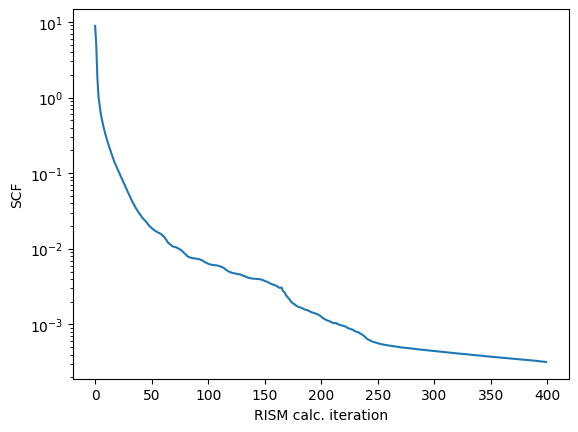

In [ ]:
scf_err = pdb.err()
fig,ax = plt.subplots()
ax.plot(scf_err)
ax.set_yscale('log')
ax.set_xlabel('RISM calc. iteration')
ax.set_ylabel('SCF')


* our error tolerance isnt _that_ bad
* but its always better to have a smaller convergence value
* optimizes the self-consistent iterations by considering the
changes made in previous steps. The math form of an n-layer DIIS is
as follows:



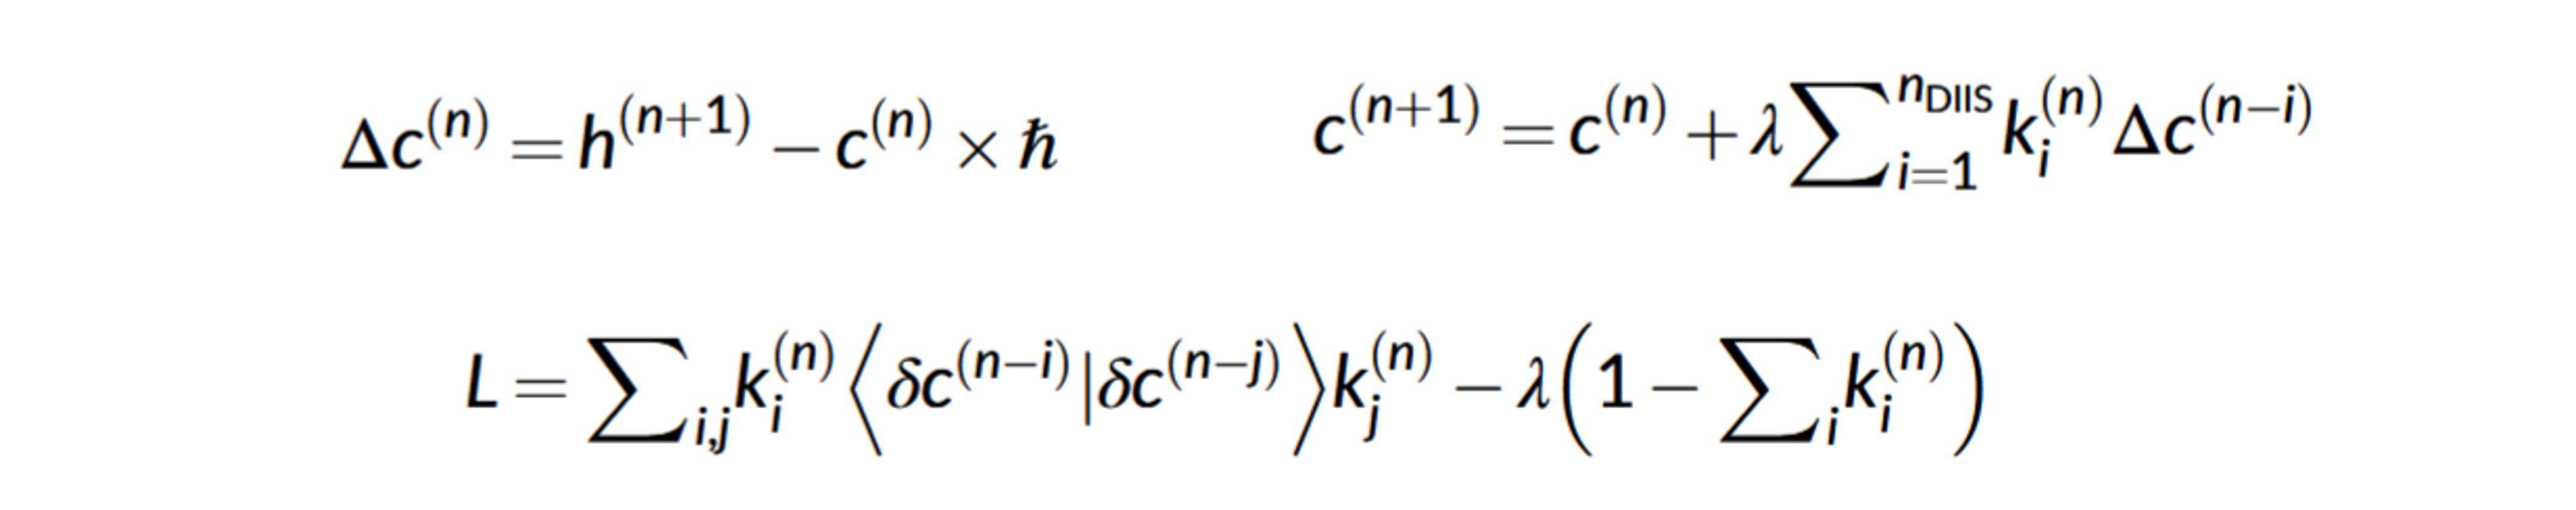

* where the factors $k_i^{n}$ are obtained by solving the DIIS Lagrange equation of historical changes for each grid (bottom)
* a 5-DIIS (std. value) would mean that we would consider the past values at the grid point for previous 5 cycles
* we can set the number of DIIS mixing steps to use
* this will cause our calculation to converge slower, but perhaps overcome local maxima

In [ ]:
pdb.get_help('diis')

eprism3d 1.2.6 (c) 2022 Cao Siqin
111     -ndiisrism              (-ndiis) DIIS steps for RISM, default: 0 or 5
117     -ndiishi                (-ndiis) DIIS steps for HI, default: 0 or 5
 # EPRISM3D is free software. You can use, modify or redistribute under the
 # terms of the GNU Lesser General Public License v3:
 # https://www.gnu.org/licenses/lgpl-3.0.en.html


* just use the flag shown in the help function to set the parameter i.e. -ndiis means we call .ndiis

In [ ]:
pdb.ndiis = 10
pdb.report('diis_increase_pdb')

* increasing the N-DIIS will also increase our allocated RAM usage

In [ ]:
pdb.test()

'166.1MB'

* lets run now with increased DIIS (< 1min)

In [ ]:
pdb.kernel()

Calculation finished in 306 steps 
err_tol: 0.0001 actual: 9.95447e-05 


* comparing the error of the two runs we can see that increasing the DIIS also increases our convergence rate and helps mainintain a 'smoother' error curve

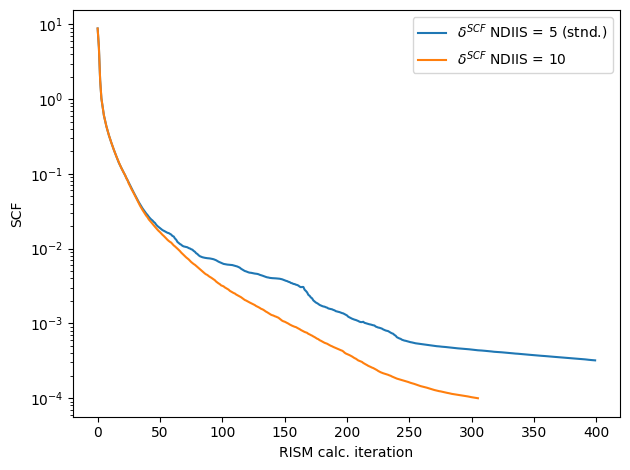

In [ ]:
diis_scf_err = pdb.err()
fig,ax = plt.subplots()
ax.plot(scf_err,label="$\delta^{SCF}$ NDIIS = 5 (stnd.)")
ax.plot(diis_scf_err,label=f"$\delta^{{SCF}}$ NDIIS = {pdb.ndiis}")
ax.set_yscale('log')
ax.set_xlabel('RISM calc. iteration')
ax.set_ylabel('SCF')
ax.legend()
fig.tight_layout()

* if you so desire, we can run a test using DIIS increase

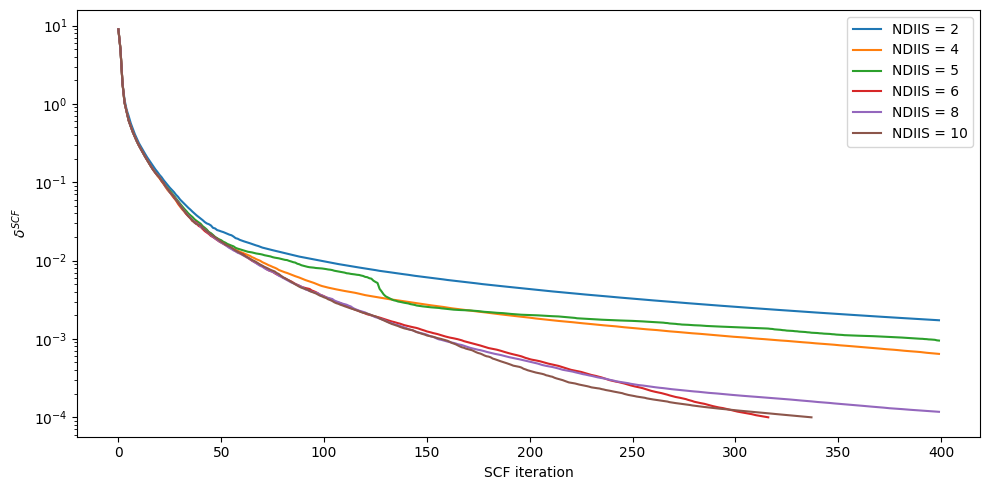

In [ ]:
#@title DIIS increase test
#@markdown $\approx$ 7min (not required)
#%%capture
out = []
for i in range(0,10,2):
  pdb.report(f'ndiis_{i}')
  pdb.ndiis = i
  pdb.kernel()
  pdb.append(pdb.err())

fig,ax = plt.subplots(figsize=(10,5))
ii = [i for i in range(0,10,2)]
for i,vals in zip(ii,out[1:]):
  ax.plot(vals,label=f"NDIIS = {i+2}")
  if i == 2: # we will show our errors in order (for asthetic reasons)
    ax.plot(scf_err,label="NDIIS = 5")
ax.plot(diis_scf_err,label="NDIIS = 10")

ax.set_yscale('log')
ax.set_xlabel('SCF iteration')
ax.set_ylabel('$\delta^{SCF}$')
ax.legend()
fig.tight_layout()

**visualizing resutls**

* lets extract our atomic-density from the calculation

In [ ]:
g_r = pdb.select_grid('guv')

* we can now visualize our results

Text(0.5, 0.98, '$g(\\vec{r})$ at slice 27 $\\mathring{A}$')

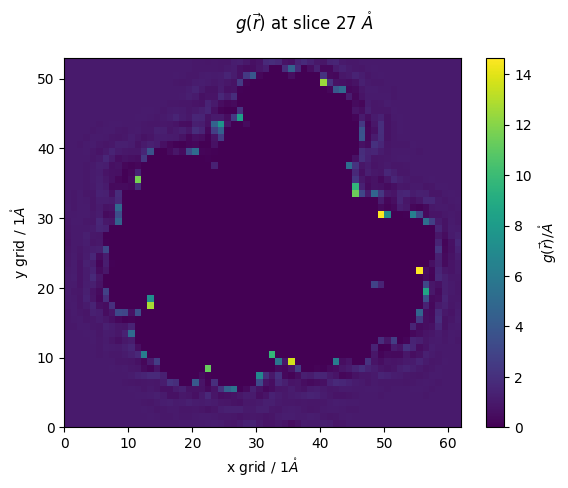

In [ ]:
z_slice = 27 # @param {type:"slider", min:1, max:91, step:1}
fig,ax = plt.subplots()
#z_slice = 10
p = ax.pcolormesh(g_r[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(20,100)
#ax.set_xlim(10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
fig.suptitle(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')

* lets make use of epipy's select commands to investigate our RISM calculation
* epipy uses similar selection language to MDAnalysis and MDtraj
* here, we will select densities around 4A of all of our proteins residues

In [ ]:
selected_grid = pdb.select_grid('guv around 4 resname LYS')

Text(0.5, 1.0, '$g(\\vec{r})$ at slice 27 $\\mathring{A}$')

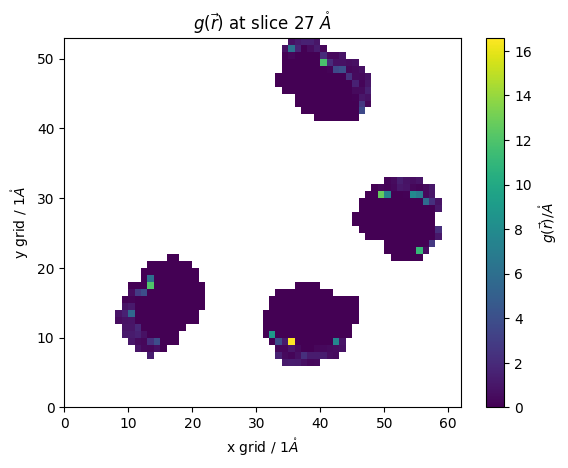

In [ ]:
#@markdown lets vizualize our selected areas
z_slice = 27 # @param {type:"slider", min:0, max:91, step:1}
fig,ax = plt.subplots()#figsize=(10,3))
#z_slice = 10
p = ax.pcolormesh(selected_grid[z_slice])
ax.set_ylabel(f'y grid / {pdb.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {pdb.resolution}$\\mathring{{A}}$')
#ax.set_ylim(None,20)#,100)
#ax.set_xlim(None,20)#10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
ax.set_title(f'$g(\\vec{{r}})$ at slice {z_slice*pdb.resolution} $\\mathring{{A}}$')


* this allows us to better analyze our system
* kets say for example, we want to see our $g(r)$ around our individual residues (≈ 20s)

Text(0.5, 1.0, 'Mean $g(\\vec{r})$ in  first solvation shell')

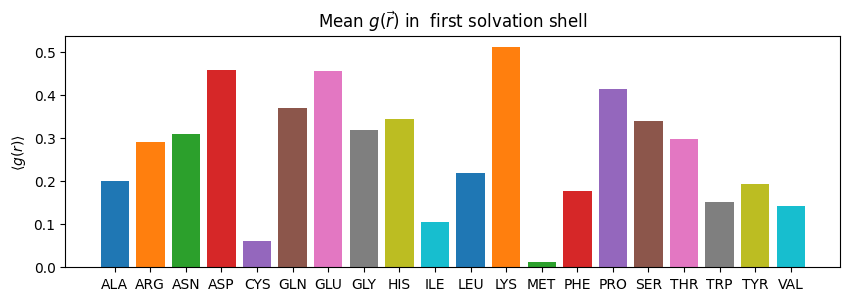

In [ ]:
#@markdown
# first we create a list of the residues that are in our protein
pdb_residues = np.unique(md.Universe(f'fixed_{PDB_ID}.gro').select_atoms('protein').resnames)
# then make a dictionary of these names
density_dict = dict(zip(pdb_residues,[[] for _ in pdb_residues]))

for name in pdb_residues:
  ss = il6.select_grid(f'guv around 4 resname {name}')
  # when doing this calculation we must ignore the NaN values
  density_dict[name] = np.ma.array(ss, mask=np.isnan(ss)).mean()
  # we will just take the mean value of our g(r)

fig,ax = plt.subplots(figsize=(10,3))
for name in density_dict.keys():
  ax.bar(name, density_dict[name])
ax.set_ylabel("$\\langle g(r)\\rangle$")
ax.set_title("Mean $g(\\vec{r})$ in  first solvation shell")

* we can select other values too, for example free energy around our residues

Text(0.5, 1.0, 'Mean $U(\\vec{r})$ in  first solvation shell')

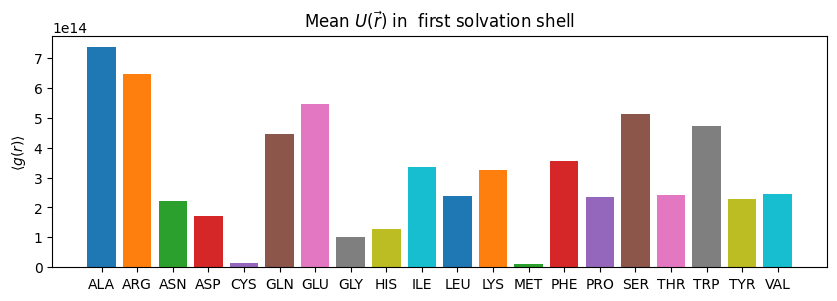

In [ ]:
#@markdown
# first we create a list of the residues that are in our protein
pdb_residues = np.unique(md.Universe('fixed_1ALU.gro').select_atoms('protein').resnames)
# then make a dictionary of these names
density_dict = dict(zip(pdb_residues,[[] for _ in pdb_residues]))

for name in pdb_residues:
  ss = il6.select_grid(f'uuv around 4 resname {name}')
  # when doing this calculation we must ignore the NaN values
  density_dict[name] = np.ma.array(ss, mask=np.isnan(ss)).mean()
  # we will just take the mean value of our g(r)

fig,ax = plt.subplots(figsize=(10,3))
for name in density_dict.keys():
  ax.bar(name, density_dict[name])
ax.set_ylabel("$\\langle g(r)\\rangle$")
ax.set_title("Mean $U(\\vec{r})$ in  first solvation shell")

* if we want to select more specific we can supply an array of our corrdinates we want to select around
* this can be any arbitrary coordinates
* for now, we will use MDAnalysis to select the Nitrogens in our LYS residues and look at $g(r)$ within the first solvation shell
* and compare this with oxygen

In [ ]:
sel = md.Universe(f'fixed_{PDB_ID}.gro').select_atoms('(resname LYS) and (name N)').positions
oo = pdb.select_grid('coul around 4',sel)

Text(0.5, 0.98, '$g(\\vec{r})$ at slice 27 $\\mathring{A}$')

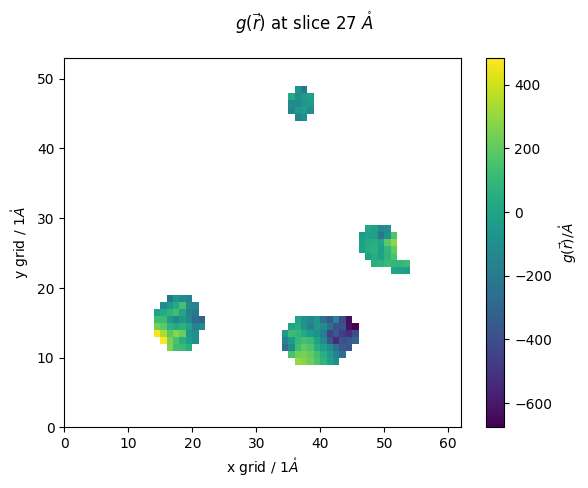

In [ ]:
sel = md.Universe('fixed_6OUH.gro').select_atoms('(resname LYS) and (name N)').positions
oo = il6.select_grid('coul around 4',sel)#resname LYS')
z_slice = 27 # @param {type:"slider", min:1, max:91, step:1}
fig,ax = plt.subplots()
#z_slice = 10
p = ax.pcolormesh(oo[z_slice])
ax.set_ylabel(f'y grid / {il6.resolution}$\\mathring{{A}}$')
ax.set_xlabel(f'x grid / {il6.resolution}$\\mathring{{A}}$')
#ax.set_ylim(20,100)
#ax.set_xlim(10,65)
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
fig.suptitle(f'$g(\\vec{{r}})$ at slice {z_slice*il6.resolution} $\\mathring{{A}}$')

* We can rerun with higher resolution if we want, but for now we will leave it a little-pixelated
* lets proceed with our investigation by checking our interaction energy on each grid point

* Now lets place waters on our grid
* we will select the top 100 atomic-density ( $g(\vec{r})$ ) peaks and place oxygen

In [ ]:
number_waters_to_place = len(md.Universe(f'{PDB_ID}.pdb').select_atoms('resname HOH'))
placed_waters = pdb.placement(number_waters_to_place,filename='guv_diis_increase_pdb.txt',write_pdb=True,outname='placed_waters')

In [ ]:
#@markdown Lets align our original PDB file to our modified and shifted RISM pdb
%%capture
u1 = md.Universe(f'fixed_{PDB_ID}.gro')
u2 = md.Universe(f'placed_waters.pdb')
#u2.dimensions = [il6.grid[0],il6.grid[1],il6.grid[2],90,90,90]
md.Merge(u1.atoms,u2.atoms).atoms.write('merged_pdb.pdb')
from pymol import cmd
cmd.load(f"{PDB_ID}.pdb")
cmd.load("merged_pdb.pdb")
cmd.align("polymer and name CA and (merged_pdb)",f"polymer and name CA and ({PDB_ID})",quiet=0,object="aln",reset=1)
#cmd.align("polymer and name CA and (1ALU)","polymer and name CA and (merged_pdb)",quiet=0,object="aln",reset=1)
cmd.save("aligned_merged_pdb.pdb","merged_pdb")
cmd.delete(f"{PDB_ID}")
cmd.delete("merged_pdb")
cmd.delete("aligned_merged_pdb")

In [ ]:
#@markdown View our placed waters
md.Universe("aligned_merged_pdb.pdb").select_atoms("resname HOH").atoms.write('aligned_waters.pdb')
md.Universe(f"{PDB_ID}.pdb").select_atoms("resname HOH").atoms.write('orig_waters.pdb')
disp = py3Dmol.view()
disp.addModel(open(f'{PDB_ID}.pdb','r').read(),'pdb')
#disp.addModel(open('aligned_merged_pdb.pdb', 'r').read(),'pdb')
#u1 = md.Universe('fixed_1ALU.gro')
#disp.addModel(open('fixed_1ALU.gro','r').read(),'gro')
#u2 = md.Universe('il6_waters.pdb')
disp.setStyle('cartoon')
disp.addModel(open('aligned_waters.pdb', 'r').read(),'pdb')
#disp.addModel(open('il6_waters.pdb', 'r').read(),'pdb',)
#disp.setStyle({'model': -1}, {'sphere': {}})
disp.setStyle({'model': -1}, {'sphere': {'color':'cyan'}})
disp.addModel(open('orig_waters.pdb', 'r').read(),'pdb')
disp.setStyle({'model': -1}, {'sphere': {'color':'red'}})
#disp.addUnitCell()
disp.addLabel('Cyan: RISM , Red: True')#,"bottomCenter")#{'alignment':"bottomCenter"},{'fontColor':'cyan'})#:{'color':'cyan'}})#,{'color':'red'})

disp.zoomTo()

disp.show()

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@markdown now lets measure RMSD between nearest neighbors
from MDAnalysis.lib.distances import capped_distance
from scipy.optimize import linear_sum_assignment
def optimal_mean_squared_distance(list1, list2):
    #list1 = np.array(list1)
    #list2 = np.array(list2)
    n = len(list1)
    assert len(list2) == n, "Lists must be the same length"
    # Build the cost matrix: mean squared distances
    cost_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = np.mean((list1[i] - list2[j]) ** 2)
    # Use the Hungarian algorithm to find the minimal total MSD pairing
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Extract the pairs and compute total mean squared distance
    pairs = [(list1[i], list2[j]) for i, j in zip(row_ind, col_ind)]
    total_msd = cost_matrix[row_ind, col_ind].sum()
    mean_msd = total_msd / n
    return mean_msd, pairs
###################################
def minimize_rmsd(distances,pairs,threshold_dist=999):
    """ I uh made this
    to search through distances and corrresponding pairs, the output is the pair index that has the smallest distance between
    indexd originial pairs, i.e. pair 1,2,3 the output would be whatever corresponding unique pair minimizes the distance
    it finishes suspeicously fast....
    returns a list of the unique pair"""
    d = dict(zip(np.unique(pairs[:,0]),np.empty(len(np.unique(pairs[:,0])))))
    already_used = []
    for item in d.keys():
        min_dist = threshold_dist
        for pair, dist in zip(pairs[np.where(pairs[:,0] == item)][:,1],distances[np.where(pairs[:,0] == item)]):
            if (min_dist > dist) and (len(np.where(np.array([d[i] for i in d.keys() if i != item]) == pair)[0]) < 1):
                d[item] = int(pair)
                min_dist = dist
    return [int(i) for i in list(d.values())]

placed  = md.Universe('aligned_waters.pdb').select_atoms("resname HOH").positions
tru = md.Universe(f'{PDB_ID}.pdb').select_atoms("resname HOH").positions
# organize the groups for the next calc
if len(tru) > len(placed):
    print('tru',len(tru),'vv',len(placed))
    placed, tru = tru, placed
    print('tru',len(tru),'vv',len(placed))
# then find the distances and pairs, cap distance at 50 to save cost
pairs, distances = capped_distance(tru,placed,50,return_distances=True,method='pkdtree')
print("distance computed")
new_vv = placed[minimize_rmsd(distances=distances,pairs=pairs)]
# select the atoms from the largest group that are closest to the smaller group
del distances
del pairs
msd,_ = optimal_mean_squared_distance(tru,new_vv)
print("==================")
print("==================")
print("RMSD",msd**0.5)
print("==================")
print("==================")

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


distance computed
RMSD 2.4829619009482546


* lets use our selection commands to get our free energy values of the waters we just placed
* here, we use the coordinates from our placement, and use them to select the energies from our calculation

In [ ]:
placed_water_energies = pdb.select_grid('uuv get',placed_waters)

* we can now add these energies into our waters pdb as tempfactors
* this is the easiest way to vizualize them in VMD/PyMol
* for our jupyter embedded model we will just select the water with the highest energy

In [ ]:
#@markdown View Results
placed_waters = md.Universe('aligned_waters.pdb')
placed_waters.add_TopologyAttr('tempfactors',placed_water_energies)
energy_of_highest_water = np.min(placed_waters.atoms.tempfactors)
high_energy_water_index = np.where(placed_water_energies == energy_of_highest_water)[0][0]
placed_waters.select_atoms(f'id {high_energy_water_index}').write('energy.pdb')

disp = py3Dmol.view()
disp.addModel(open(f'energy.pdb','r').read(),'pdb')
disp.setStyle({'model': -1}, {'sphere': {'color':'cyan'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.7,'colorscheme':{'prop':'b','gradient':'sinebow','min':0,'max':70}})

disp.addModel(open(f'{PDB_ID}.pdb', 'r').read(),'pdb')
#disp.setStyle({'model': -1}, {'sphere': {'color':'red'}})
#disp.addUnitCell()
disp.addLabel(f'Cyan: High energy RISM water {energy_of_highest_water:0.3f}')#,"bottomCenter")#{'alignment':"bottomCenter"},{'fontColor':'cyan'})#:{'color':'cyan'}})#,{'color':'red'})

disp.zoomTo()

disp.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# DONE

We encourage you to play around with this tutorial and substitute your own PDB file  